# Kaggleの物件価格分析、RandomForest/LightGBM

kaggleデータを使用して、不動産価格の分析を行います。<br>
今回は
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview
にあるデータを使います。<br>
<br>
コンペに頻出するバギングとブースティングで簡易的なモデル実装を行います。

## 1.ライブラリのインポート

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2.データの読み込み

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## データの確認・EDA

In [6]:
#データのカラムと数
print(train.columns)
print(train.shape)
print(test.columns)
print(test.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

今回は**SalePrice**の予測になりますので、<br>
それ以外のカラムから特徴量を探索していきます。<br>

In [7]:
#データのデータ型を確認
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

intとobjectが入り混じっているので、<br>
場合によっては処理が必要。

In [8]:
#データの基本統計量の表示
train.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


カラムの数が多すぎるので少しずつ扱うデータを絞っていきます。
まずは、int・float型のデータから扱うデータを決めていきます。

In [9]:
#相関係数でデータを見る
train_corr = train.corr()
print(train_corr.head())

                   Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id           1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass   0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea     -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual -0.028365    0.032628     0.251646  0.105806     1.000000   

             OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id              0.012609  -0.012713     -0.021998   -0.050298   -0.005024   
MSSubClass     -0.059316   0.027850      0.040581    0.022936   -0.069836   
LotFrontage    -0.059213   0.123349      0.088866    0.193458    0.233633   
LotArea        -0.005636   0.014228      0.013788    0.104160    0.214103   
OverallQual    -0.091932   0.572323      0.550684    0.411876    0.239666   

             ...  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
Id           ...   -0.02964

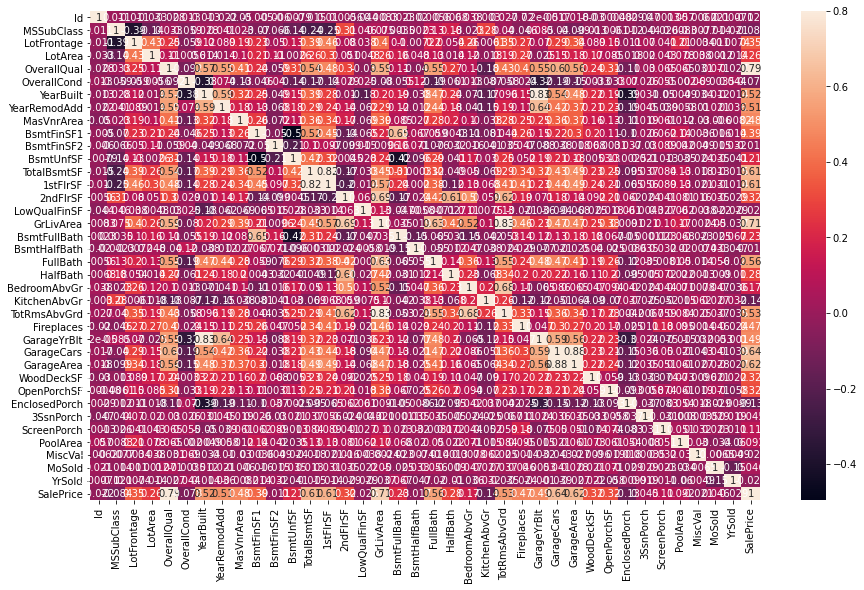

In [10]:
#ヒートマップで可視化
f, ax = plt.subplots(figsize=(15,9))
sns.heatmap(train_corr, annot=True,vmax=.8)
plt.show()

ヒートマップで可視化したもので、重要そうなカラムを抜き出して改めてヒートマップを見てみます。

In [11]:
train_int_features = train[['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd','GarageCars', 'GarageArea','SalePrice']]

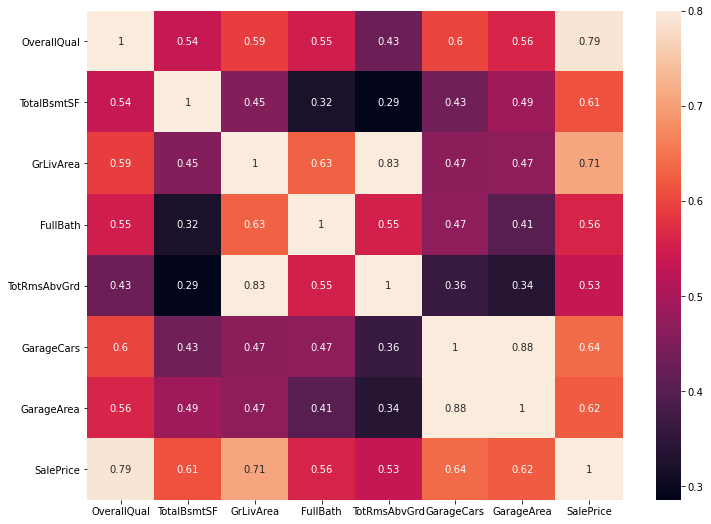

In [12]:
train_int_corr = train_int_features.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(train_int_corr, annot=True,vmax=.8)
plt.show()

SalePriceとの相関係数が０．５以上のものだけを抜粋しました。<br>
住宅価格に非常にかかわっている特徴だということが予想されます。<br>
（部屋数、エリア情報、ガレージの数など）<br><br>
これをそのまま使うのではなく、欠損などを調べて使用できるかも見ていきます。

In [13]:
# NaNの数をカウント
for i in train_int_features:
    print(train_int_features[i].isnull().sum())

0
0
0
0
0
0
0
0


In [14]:
# 各カラムのユニーク数を確認
for i in train_int_features:
    print(train_int_features[i].value_counts())

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64
0       37
864     35
672     17
912     15
1040    14
        ..
1210     1
727      1
1205     1
1203     1
2046     1
Name: TotalBsmtSF, Length: 721, dtype: int64
864     22
1040    14
894     11
848     10
1456    10
        ..
2792     1
2794     1
1349     1
1347     1
2054     1
Name: GrLivArea, Length: 861, dtype: int64
2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64
2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64
0       81
440     49
576     47
240     38
484     34
        ..
671      1
342      1
673      1
675      1
1418     1
Name: GarageArea, Length: 441, dtype: int64
140000    20
135000    17
155000    14
145000    14
190000    13
          ..
3

欠損地はなさそうですが、NaNの代わりに「０」で欠損を埋めている可能性のあるデータがあります。<br>
ただ、訓練データだけではなく、テストデータにも「０」が含まれているため、<br>
このまま分析に使っていきます。

# ③モデル作成

今回は回帰・分類ともによく使われるバギングとブースティングでモデルを作り、<br>
評価を比較していきたいと思います。<br>
精度が低い場合は特徴量の追加やパラメータチューニングを行います。

**ランダムフォレストの場合**

In [15]:
# 教師データと訓練データの格納
x = train_int_features.drop('SalePrice', axis=1)
y = train['SalePrice']

In [16]:
# 標準化を行う
from sklearn.preprocessing import StandardScaler
sts = StandardScaler()
x = sts.fit_transform(x)

In [17]:
# データの分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20, random_state=0)

In [18]:
#ランダムフォレストの実装
from sklearn.ensemble import RandomForestRegressor

In [19]:
RF = RandomForestRegressor(n_estimators=50, max_depth=5)

In [20]:
# 訓練
RF.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=50)

In [21]:
# 訓練データとテストデータの予測値を格納
RF_train_pred = RF.predict(X_train)
RF_test_pred = RF.predict(X_test)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error 

In [23]:
# RMSEとMAEの計算
print(np.sqrt(mean_squared_error(y_train, RF_train_pred)), mean_absolute_error(y_train, RF_train_pred))
print(np.sqrt(mean_squared_error(y_test, RF_test_pred)), mean_absolute_error(y_test, RF_test_pred))

26317.740773303758 18812.306388661986
33605.20552821655 21048.22664014019


過学習は起きてないですが、精度はあまりよくありません。<br>
では、LightGBMを使った場合も見ていきましょう。

**LightGBMの場合**

In [44]:
# LightGBMのインポート
import lightgbm as lgb

In [45]:
#データのセット
#訓練データ
lgb_train = lgb.Dataset(X_train, y_train)
#検証データ
lgb_test = lgb.Dataset(X_test, y_test)

In [46]:
#パラメータの設定
# RMSE, 木の深さは5,学習率はデフォルト
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的は回帰  
        'metric': {'rmse'}, # 評価指標
        'learning_rate': 0.01,
        'num_leaves': 20,
        'min_data_in_leaf': 1,
        'num_iteration': 1000, #1000回学習
        'verbose': 1
}

In [47]:
#学習の開始
model = lgb.train(params, # パラメータ
            train_set=lgb_train, # トレーニングデータの指定
            valid_sets=lgb_test, # 検証データの指定
            early_stopping_rounds=100 # 100回ごとに検証精度の改善を検討
               )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 7
[LightGBM] [Info] Start training from score 180808.898973
[1]	valid_0's rmse: 82360.1
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 81625.7
[3]	valid_0's rmse: 80899.6
[4]	valid_0's rmse: 80183
[5]	valid_0's rmse: 79472.4
[6]	valid_0's rmse: 78782
[7]	valid_0's rmse: 78090.8
[8]	valid_0's rmse: 77422.3
[9]	valid_0's rmse: 76749
[10]	valid_0's rmse: 76084.8
[11]	valid_0's rmse: 75430.2
[12]	valid_0's rmse: 74782.2
[13]	valid_0's rmse: 74143.2
[14]	valid_0's rmse: 73512.6
[15]	valid_0's rmse: 72888.2
[16]	valid_0's rmse: 72264.7
[17]	valid_0's rmse: 71666.3
[18]	valid_0's rmse: 71081.6
[19]	valid_0's rmse: 70474.1
[20]	valid_0's rmse: 69927.5
[21]	valid_0's rmse: 69352

アーリーストッピングは424の時点で止まっており、それ以上は学習は進めても改善は見込めないようです。<br>
検証データのRMSEを見ると、ブースティングのほうが若干結果が良いことがわかります。<br>
さらに決定係数も算出していきます。

In [35]:
from sklearn.metrics import r2_score

In [52]:
#RFの決定係数
r2_score(y_test, RF_test_pred)

0.8364705511298169

In [51]:
#LightGBMの決定係数
LB_pred = model.predict(X_test)
r2_score(y_test, LB_pred)

0.8641902491498547

決定係数もブースティングのほうが当てはまりが良いという結果になりました。